In [1]:
# Copyright (C) 2020 Luceda Photonics
# Modified by Ongun Arisev (ongunarisev@gmail.com)
from siepic import all as pdk
from ipkiss3 import all as i3
import numpy as np
import pylab as plt
from mzi_pcell_bdc import MZI_BDC

In [2]:
def define_control_point(delay_length, bend_radius, control_point_y):
    """Defines a control point based on the desired delay_length"""

    def f(x):
        device = MZI_BDC(
            control_point=(x[0], control_point_y),
            bend_radius=bend_radius,
        )
        right_arm_length = device.get_connector_instances()[1].reference.trace_length()
        left_arm_length = device.get_connector_instances()[0].reference.trace_length()
        current_delay_length = right_arm_length - left_arm_length
        cost = current_delay_length - delay_length
        return np.abs(cost)

    from scipy.optimize import minimize

    control_point_x = minimize(f, x0=np.array(70.0), tol=1e-2, bounds=((45.0, 200.0),)).x[0]
    return control_point_x, control_point_y

In [3]:
# Parameters for the MZI sweep
delay_lengths = [60.0, 120.0, 240.0]
bend_radius = 5.0
x0 = 40.0
y0 = 20.0
spacing_x = 180.0

insts = dict()
specs = []

In [4]:
# Create the floorplan
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(605.0, 410.0))

# Add the floorplan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))

In [5]:
# Create the MZI sweep
for ind, delay_length in enumerate(delay_lengths):
    cp = define_control_point(
        delay_length=delay_length,
        bend_radius=bend_radius,
        control_point_y=240.0,
    )

    # Instantiate the MZI
    mzi = MZI_BDC(
        name="MZI{}".format(ind),
        control_point=cp,
        bend_radius=bend_radius,
    )

    # Calculate the actual delay length and print the results
    right_arm_length = mzi.get_connector_instances()[1].reference.trace_length()
    left_arm_length = mzi.get_connector_instances()[0].reference.trace_length()
    actual_delay_length = right_arm_length - left_arm_length

    print(
        mzi.name,
        "Desired delay length = {} um".format(delay_length),
        "Actual delay length = {} um".format(actual_delay_length),
        "Control point = {}".format(cp),
    )

    # Add the MZI to the instances dict and place it
    mzi_cell_name = "mzi{}".format(ind)
    insts[mzi_cell_name] = mzi
    specs.append(i3.Place(mzi_cell_name, (x0, y0)))

    x0 += spacing_x

MZI0 Desired delay length = 60.0 um Actual delay length = 60.0000445200643 um Control point = (61.84614031141907, 240.0)
MZI1 Desired delay length = 120.0 um Actual delay length = 120.00000314310324 um Control point = (91.84611962293853, 240.0)
MZI2 Desired delay length = 240.0 um Actual delay length = 240.000002133407 um Control point = (151.8461191180904, 240.0)


In [6]:
# Create the final design with i3.Circuit
cell = i3.Circuit(
    name="mzi_bdc_with_set_deltaL",
    insts=insts,
    specs=specs,
)

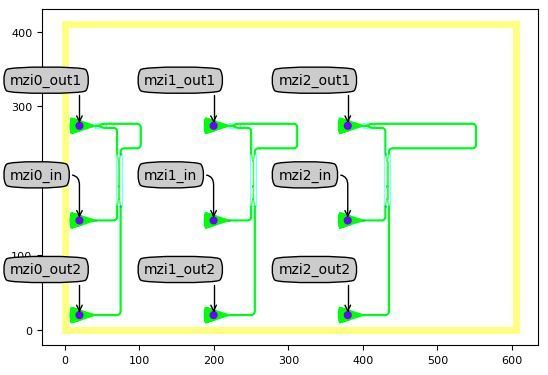

C:\Users\ongun\PycharmProjects\ipkiss_training\mzi_bdc_with_set_deltaL.gds

In [7]:
# Layout
cell_lv = cell.Layout()
cell_lv.visualize(annotate=True)
cell_lv.write_gdsii("mzi_bdc_with_set_deltaL.gds")

In [8]:
# Circuit model
cell_cm = cell.CircuitModel()
wavelengths = np.linspace(1.52, 1.58, 4001)
S_total = cell_cm.get_smatrix(wavelengths=wavelengths)

C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\simulation\engines\caphe_circuit_sim\caphenodegenerator.py:376: UserWarning: The following child nodes are not connected and will be removed:
floorplan
  warn(msg)


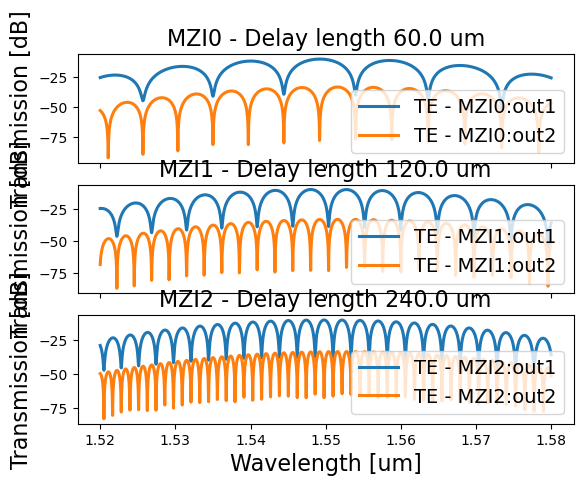

Done


In [9]:
# Plotting
fig, axs = plt.subplots(3, sharex="all")

for ind, delay_length in enumerate(delay_lengths):
    tr_out1 = i3.signal_power_dB(S_total["mzi{}_out1:0".format(ind), "mzi{}_in:0".format(ind)])
    tr_out2 = i3.signal_power_dB(S_total["mzi{}_out2:0".format(ind), "mzi{}_in:0".format(ind)])

    axs[ind].plot(wavelengths, tr_out1, "-", linewidth=2.2, label="TE - MZI{}:out1".format(ind))
    axs[ind].plot(wavelengths, tr_out2, "-", linewidth=2.2, label="TE - MZI{}:out2".format(ind))

    axs[ind].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ind].set_title("MZI{} - Delay length {} um".format(ind, delay_length), fontsize=16)
    axs[ind].legend(fontsize=14, loc=4)

axs[2].set_xlabel("Wavelength [um]", fontsize=16)
plt.show()

print("Done")